In [103]:
# %pip install tensorflow==2.12.0 scikit-learn numpy pandas==1.5.2 rich==13.3.3 matplotlib


In [104]:
# %pip install ta==0.10.2 yfinance==0.2.13

In [105]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7960059401465854295
xla_global_id: -1
]


In [106]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [107]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib
import talib as ta

import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [108]:
# Load the Bitcoin price data
bitcoin_data = pd.read_csv(r'C:\Users\MrBios\Documents\Development\test\csv\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')  # Replace "bitcoin_data.csv" with your actual data file
bitcoin_data.dropna(inplace=True)

In [109]:
# Calculate technical indicators using TA-Lib
bitcoin_data["RSI"] = talib.RSI(bitcoin_data["Close"])
bitcoin_data["MACD"], bitcoin_data["MACD_SIGNAL"], _ = talib.MACD(bitcoin_data["Close"])

In [110]:
# remove timestamp column
bitcoin_data.drop(columns=["Timestamp"], inplace=True)

In [111]:
# get last 10000 rows
bitcoin_data = bitcoin_data.tail(10000)

In [112]:
# Prepare the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(bitcoin_data[["Close", "RSI", "MACD", "MACD_SIGNAL"]])
scaled_data = scaler.fit_transform(bitcoin_data[["Close"]])

# Create sequences of data with a given time step
time_step = 30  # Number of previous time steps to consider for predicting the next time step
X = []
y = []
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i - time_step:i, :])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# Reshape X to match the expected input shape of the model
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


In [114]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [115]:

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)	
# Compile the model


Epoch 1/50
225/225 [==============================] - 6s 15ms/step - loss: 0.0083 - val_loss: 8.5836e-04
Epoch 2/50
225/225 [==============================] - 3s 14ms/step - loss: 0.0028 - val_loss: 6.4593e-04
Epoch 3/50
225/225 [==============================] - 3s 14ms/step - loss: 0.0026 - val_loss: 2.9497e-04
Epoch 4/50
225/225 [==============================] - 3s 14ms/step - loss: 0.0023 - val_loss: 2.9324e-04
Epoch 5/50
225/225 [==============================] - 3s 14ms/step - loss: 0.0020 - val_loss: 6.6494e-04
Epoch 6/50
225/225 [==============================] - 3s 13ms/step - loss: 0.0019 - val_loss: 3.1855e-04
Epoch 7/50
225/225 [==============================] - 3s 13ms/step - loss: 0.0018 - val_loss: 3.6946e-04
Epoch 8/50
225/225 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 3.9362e-04
Epoch 9/50
225/225 [==============================] - 3s 13ms/step - loss: 0.0014 - val_loss: 3.1184e-04
Epoch 10/50
225/225 [==============================] - 

In [116]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
250/250 [==============================] - 4s 14ms/step - loss: 5.1113e-04 - val_loss: 1.1509e-04
Epoch 2/50
250/250 [==============================] - 4s 14ms/step - loss: 5.1666e-04 - val_loss: 1.1700e-04
Epoch 3/50
250/250 [==============================] - 3s 14ms/step - loss: 5.2159e-04 - val_loss: 1.6050e-04
Epoch 4/50
250/250 [==============================] - 3s 13ms/step - loss: 5.3442e-04 - val_loss: 1.1897e-04
Epoch 5/50
250/250 [==============================] - 3s 12ms/step - loss: 5.3249e-04 - val_loss: 1.5213e-04
Epoch 6/50
250/250 [==============================] - 3s 12ms/step - loss: 5.5975e-04 - val_loss: 1.5558e-04
Epoch 7/50
250/250 [==============================] - 3s 12ms/step - loss: 5.1226e-04 - val_loss: 1.6624e-04
Epoch 8/50
250/250 [==============================] - 3s 12ms/step - loss: 5.2897e-04 - val_loss: 1.5589e-04
Epoch 9/50
250/250 [==============================] - 3s 12ms/step - loss: 5.2130e-04 - val_loss: 1.7245e-04
Epoch 10/50
250/250

In [117]:
# Make predictions
predictions = model.predict(X_test)

63/63 [==============================] - 1s 6ms/step


In [118]:

# Scale the predictions back to original values
predictions = scaler.inverse_transform(predictions)


In [119]:
from sklearn.metrics import mean_squared_error
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 55364.710675171686


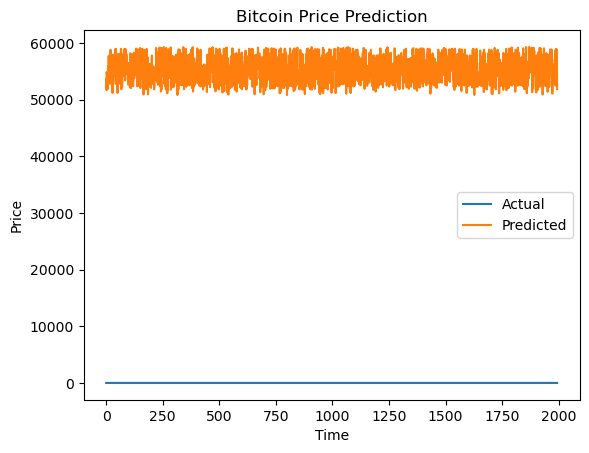

In [120]:
import matplotlib.pyplot as plt

# Plot the actual values
plt.plot(y_test, label='Actual')

# Plot the predicted values
plt.plot(predictions, label='Predicted')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
